In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,19), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,18):
            if i <= 8:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        



In [3]:
nanVals = np.sum(metaData, axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

7925 (199639, 19)
(191714, 19)


In [4]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [5]:
df.head()

,time,lat,lon,U10N_QS,U10N_dir_QS,satTimeDiff,dist,satLon,satLat,U10N_TAO,...,U10N_x_TAO2,U10N_y_TAO2,SST_TAO,RH_TAO,AIRT_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff
0,315534600.0,-8.0,265.0,5.747140,325.648834,276.0,6.455491,265.053436,-7.976122,5.926161,...,-3.276446,4.936657,23.745001,73.830002,22.930000,0.0,-0.179021,0.179021,-0.751160,0.751160
1,315535200.0,-8.0,265.0,5.747140,325.648834,-324.0,6.455491,265.053436,-7.976122,5.836925,...,-3.612193,4.592328,23.743000,73.300003,22.840000,0.0,-0.089785,0.089785,3.848846,3.848846
2,315704400.0,-8.0,265.0,6.211579,323.708984,271.0,6.615148,264.974976,-7.945916,5.541527,...,-3.463514,4.321145,23.938000,75.730003,23.200001,0.0,0.670052,0.670052,2.408997,2.408997
3,315705000.0,-8.0,265.0,6.211579,323.708984,-329.0,6.615148,264.974976,-7.945916,5.992860,...,-3.797712,4.631890,23.927999,75.599998,23.190001,0.0,0.218719,0.218719,3.108978,3.108978
4,315749400.0,-8.0,265.0,5.837174,318.623627,457.0,5.688329,265.045563,-7.975894,6.055364,...,-4.058911,4.486742,23.716999,73.879997,23.040001,0.0,-0.218190,0.218190,0.823639,0.823639


In [6]:
selectX = [#'time',
           'U10N_QS',
           'U10N_dir_QS',
           'satTimeDiff',
           'dist',
           'U10N_TAO',
           'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           'SST_TAO',
           'RH_TAO',
           'AIRT_TAO',
           #'speedDiff',
           #'directionDiff',
           'absSpeedDiff',
           'absDirectionDiff']

X = df[selectX]

In [7]:
X.head()

,U10N_QS,U10N_dir_QS,satTimeDiff,dist,U10N_TAO,U10N_dir_TAO,SST_TAO,RH_TAO,AIRT_TAO,absSpeedDiff,absDirectionDiff
0,5.747140,325.648834,276.0,6.455491,5.926161,326.399994,23.745001,73.830002,22.930000,0.179021,0.751160
1,5.747140,325.648834,-324.0,6.455491,5.836925,321.799988,23.743000,73.300003,22.840000,0.089785,3.848846
2,6.211579,323.708984,271.0,6.615148,5.541527,321.299988,23.938000,75.730003,23.200001,0.670052,2.408997
3,6.211579,323.708984,-329.0,6.615148,5.992860,320.600006,23.927999,75.599998,23.190001,0.218719,3.108978
4,5.837174,318.623627,457.0,5.688329,6.055364,317.799988,23.716999,73.879997,23.040001,0.218190,0.823639


In [8]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [9]:
normX

,U10N_QS,U10N_dir_QS,satTimeDiff,dist,U10N_TAO,U10N_dir_TAO,SST_TAO,RH_TAO,AIRT_TAO,absSpeedDiff,absDirectionDiff
0,-0.375533,0.922160,0.796828,0.856122,-0.200680,0.921069,-2.005304,-1.494575,-2.103914,-0.649198,-0.569911
1,-0.375533,0.922160,-0.935010,0.856122,-0.239603,0.861755,-2.006365,-1.587448,-2.153853,-0.739948,-0.453172
2,-0.168082,0.894452,0.782396,0.941470,-0.368448,0.855307,-1.902960,-1.161632,-1.954098,-0.149834,-0.507434
3,-0.168082,0.894452,-0.949442,0.941470,-0.171588,0.846281,-1.908263,-1.184413,-1.959647,-0.608826,-0.481054
4,-0.335318,0.821816,1.319266,0.446022,-0.144325,0.810177,-2.020153,-1.485814,-2.042878,-0.609365,-0.567180
...,...,...,...,...,...,...,...,...,...,...,...
191709,1.104623,-0.144000,-0.121046,0.845449,-0.006496,-0.270378,-0.409151,2.104705,-0.788862,1.903934,0.042651
191710,1.932325,-0.308599,0.248413,-2.119918,1.854418,-0.302614,-0.408090,1.086602,-0.256182,-0.550403,-0.297420
191711,1.932325,-0.308599,-1.483425,-2.119918,1.785705,-0.292298,-0.409151,0.988472,-0.250633,-0.390193,-0.327569
191712,1.846970,-0.229877,0.591894,-1.625904,2.335134,-0.270378,-0.458998,1.975032,-0.894288,0.203042,-0.183932


In [10]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

Text(0, 0.5, 'QS dir - TAO dir')

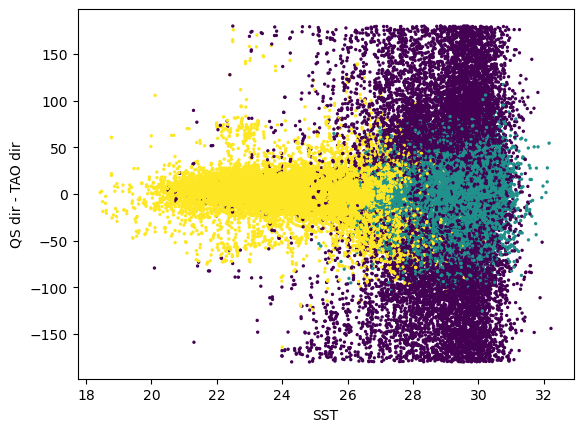

In [11]:
plt.scatter(df['SST_TAO'], df['directionDiff'], c = df['label'], s = 2)
plt.xlabel('SST')
plt.ylabel('QS dir - TAO dir')

Text(0, 0.5, 'QS speed - TAO speed')

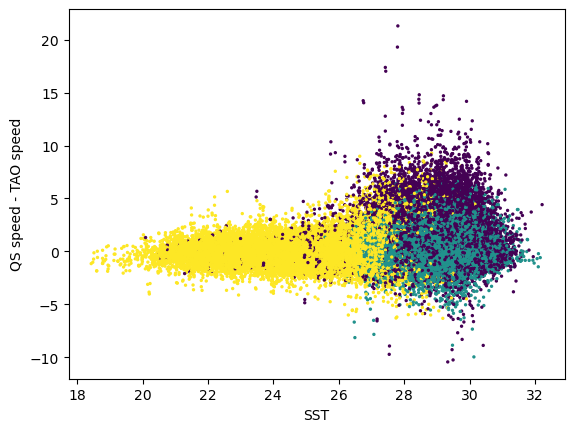

In [12]:
plt.scatter(df['SST_TAO'], df['speedDiff'], c = df['label'], s = 2)
plt.xlabel('SST')
plt.ylabel('QS speed - TAO speed')

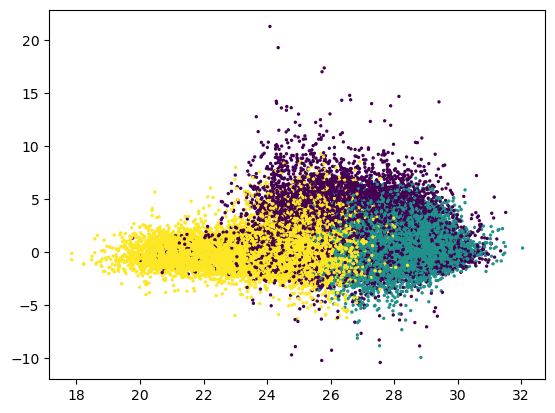

In [13]:
plt.scatter(df['AIRT_TAO'], df['speedDiff'], c = df['label'], s = 2)

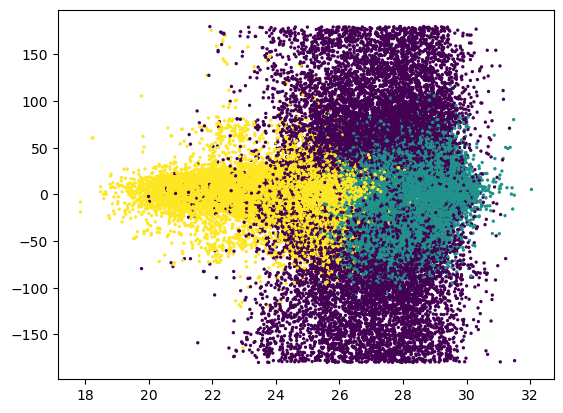

In [14]:
plt.scatter(df['AIRT_TAO'], df['directionDiff'], c = df['label'], s = 2)

Text(0, 0.5, 'SST')

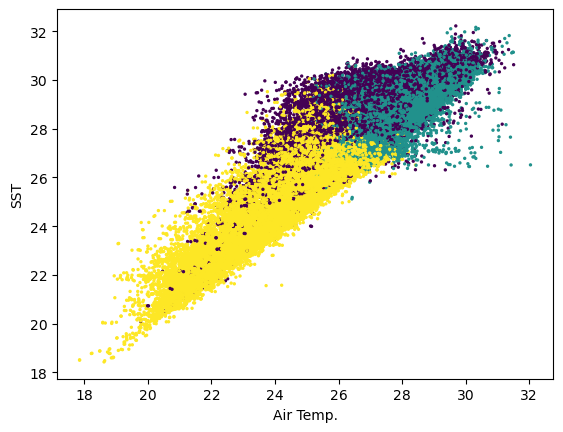

In [15]:
plt.scatter(df['AIRT_TAO'], df['SST_TAO'], c = df['label'], s = 2)
plt.xlabel('Air Temp.')
plt.ylabel('SST')

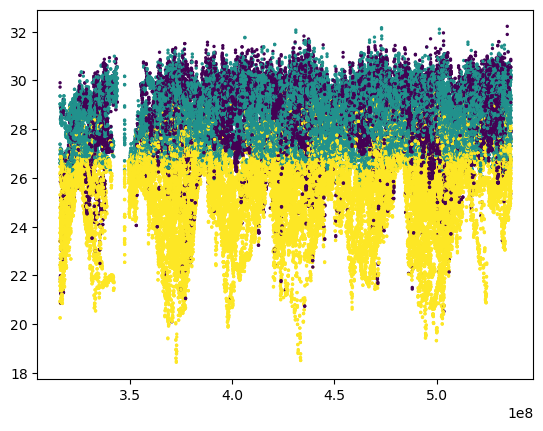

In [16]:
plt.scatter(df['time'], df['SST_TAO'], c = df['label'], s = 2)

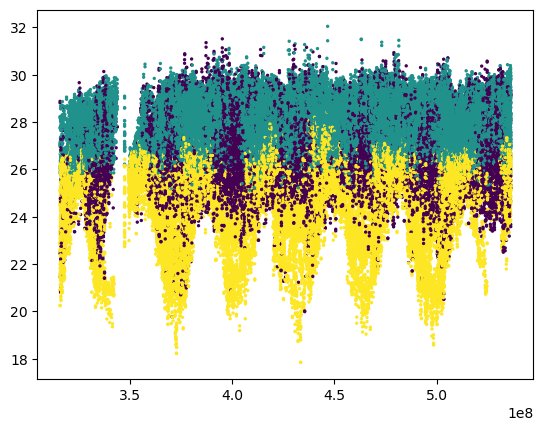

In [17]:
plt.scatter(df['time'], df['AIRT_TAO'], c = df['label'], s = 2)

Text(0, 0.5, 'SST')

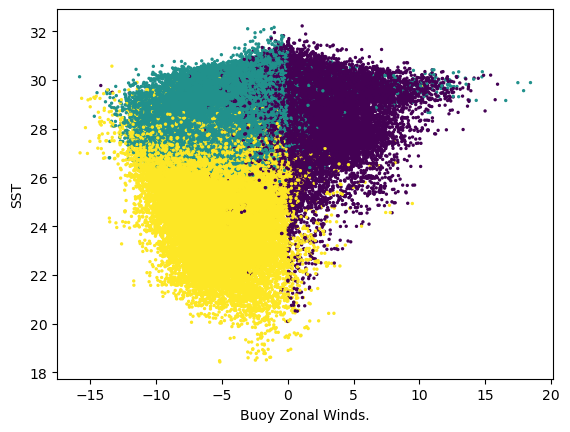

In [18]:
plt.scatter(df['U10N_x_TAO2'], df['SST_TAO'], c = df['label'], s = 2)
plt.xlabel('Buoy Zonal Winds.')
plt.ylabel('SST')

Text(0, 0.5, 'SST')

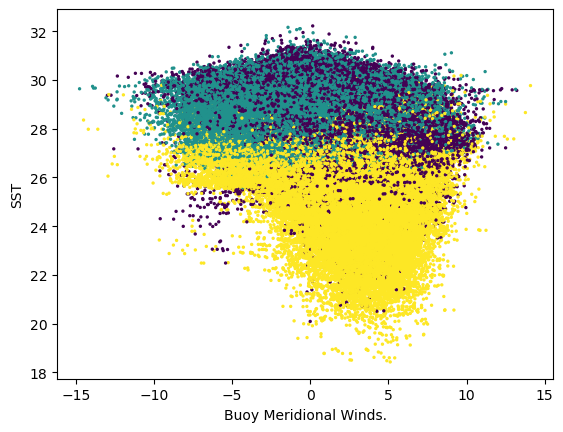

In [19]:
plt.scatter(df['U10N_y_TAO2'], df['SST_TAO'], c = df['label'], s = 2)
plt.xlabel('Buoy Meridional Winds.')
plt.ylabel('SST')

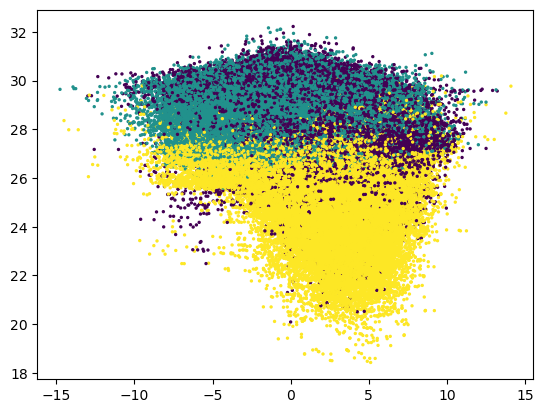

In [20]:
plt.scatter(df['U10N_y_TAO2'], df['SST_TAO'], c = df['label'], s = 2)

In [21]:
def plotTimeSeriesByClusterLabel(df, lat, lon, ax1, ax2, cluster_label=0, color='blue'):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    subDF = subDF.loc[subDF['label'] == cluster_label]

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'

    
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = Dataset(deployFileName)
    startDates = np.array(ds2.variables['startDate'])
    units = ds2.variables['startDate'].units
    cftimes = num2date(startDates, units)
    startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    endDates = np.array(ds2.variables['endDate'])
    units = ds2.variables['endDate'].units
    cftimes = num2date(endDates, units)
    endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    ds2.close()
    
    cftimes = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')
    dates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])
    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']

    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        ax1.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        ax2.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    #ax1.scatter(subDF['time'], y1, s=2, label = cluster_label)#, c = subDF['label'])
    #ax2.scatter(subDF['time'], y2, s=2, label = cluster_label)#, c = subDF['label'])

    ax1.scatter(dates, y1, s=3, label = cluster_label, c = color)
    ax2.scatter(dates, y2, s=3, label = cluster_label, c = color)
    ax1.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} speed Diff')
    ax2.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} direction Diff')

def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
    dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']
    
    ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='prism')
    ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='prism')

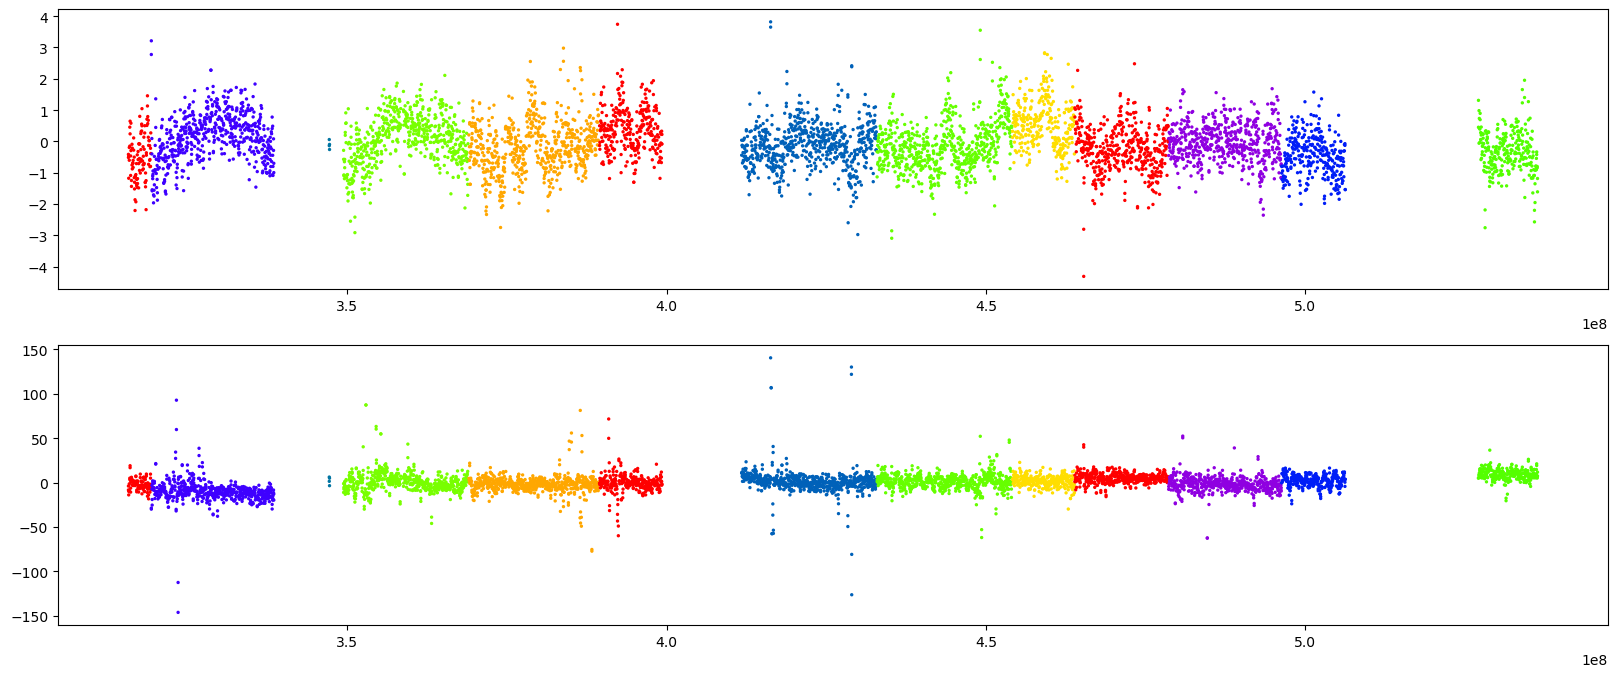

In [22]:
lat = 0
lon = -140

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

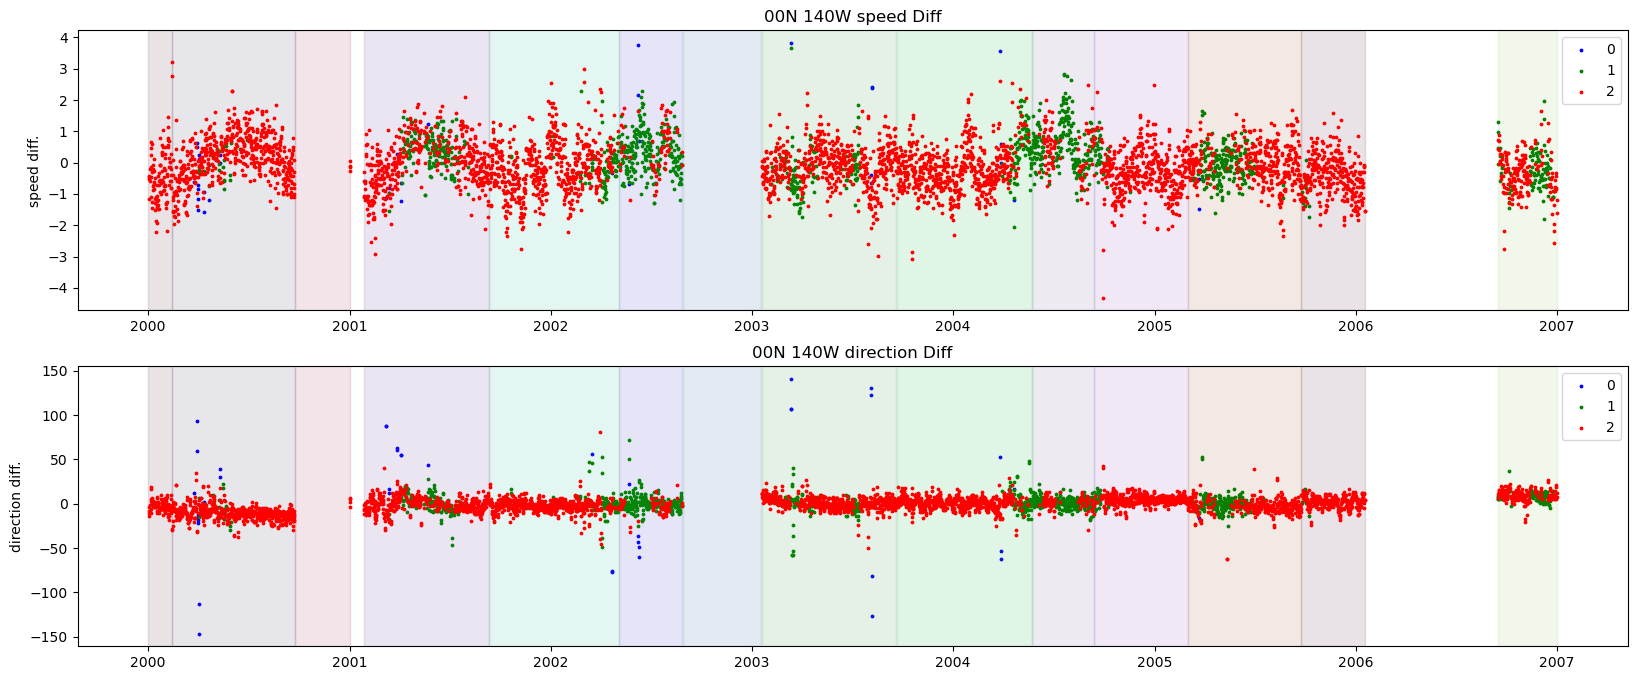

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=0, color = 'blue')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=1, color = 'green')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=2, color = 'red')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=3)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=4)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=5)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=6)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=7)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=8)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=9)
axes[0].set_ylabel('speed diff.')
axes[0].legend()

axes[1].set_ylabel('direction diff.')
axes[1].legend()

In [24]:
df.head()

,time,lat,lon,U10N_QS,U10N_dir_QS,satTimeDiff,dist,satLon,satLat,U10N_TAO,...,U10N_y_TAO2,SST_TAO,RH_TAO,AIRT_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff,label
0,315534600.0,-8.0,265.0,5.747140,325.648834,276.0,6.455491,265.053436,-7.976122,5.926161,...,4.936657,23.745001,73.830002,22.930000,0.0,-0.179021,0.179021,-0.751160,0.751160,2
1,315535200.0,-8.0,265.0,5.747140,325.648834,-324.0,6.455491,265.053436,-7.976122,5.836925,...,4.592328,23.743000,73.300003,22.840000,0.0,-0.089785,0.089785,3.848846,3.848846,2
2,315704400.0,-8.0,265.0,6.211579,323.708984,271.0,6.615148,264.974976,-7.945916,5.541527,...,4.321145,23.938000,75.730003,23.200001,0.0,0.670052,0.670052,2.408997,2.408997,2
3,315705000.0,-8.0,265.0,6.211579,323.708984,-329.0,6.615148,264.974976,-7.945916,5.992860,...,4.631890,23.927999,75.599998,23.190001,0.0,0.218719,0.218719,3.108978,3.108978,2
4,315749400.0,-8.0,265.0,5.837174,318.623627,457.0,5.688329,265.045563,-7.975894,6.055364,...,4.486742,23.716999,73.879997,23.040001,0.0,-0.218190,0.218190,0.823639,0.823639,2


In [25]:
import seaborn as sns

In [26]:
#sns.pairplot(data=df, x = 'hue="label")

In [27]:
subDFheaders = ['satTimeDiff',
                 'dist',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 'absSpeedDiff',
                 'absDirectionDiff',
                 'label']

subDFheaders = [ #'satTimeDiff',
                 #'dist',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 #'absSpeedDiff',
                 #'absDirectionDiff',
                 'label']

subDF = df[subDFheaders]

In [ ]:
#snsPlot = sns.pairplot(data=subDF, hue="label")

In [ ]:
#snsPlot.figure.savefig('allData.png', dpi = 100)

In [ ]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensity.png', dpi = 100)

In [28]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

RH_TAO AIRT_TAO


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

RH_TAO speedDiff


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'thres'
  cset = contour_func(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inst

RH_TAO directionDiff


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'thres'
  cset = contour_func(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

AIRT_TAO speedDiff


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

AIRT_TAO directionDiff


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'thres'
  cset = contour_func(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

speedDiff directionDiff


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'thres'
  cset = contour_func(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inst

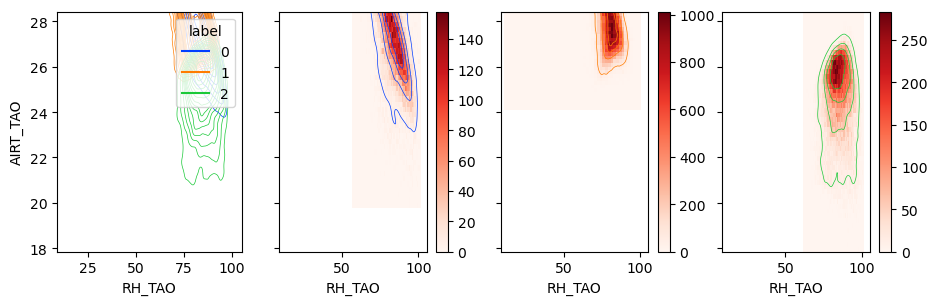

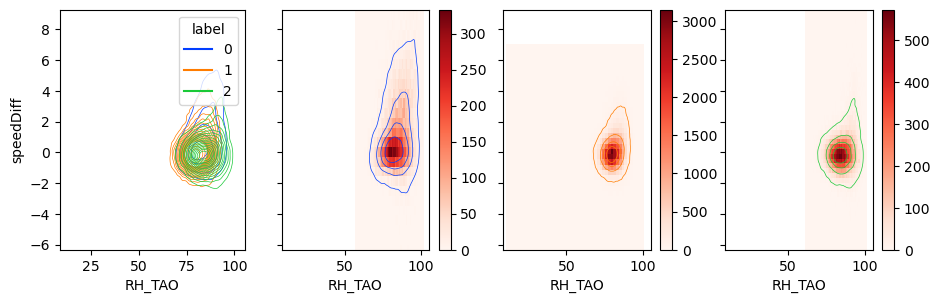

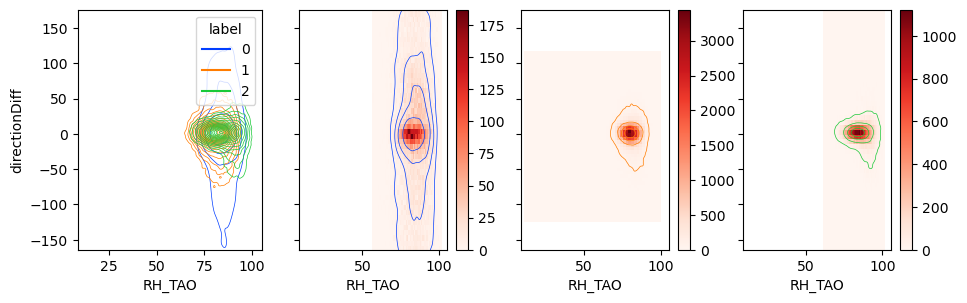

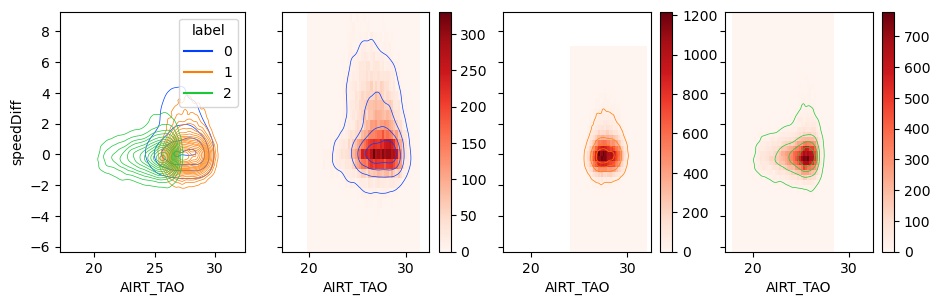

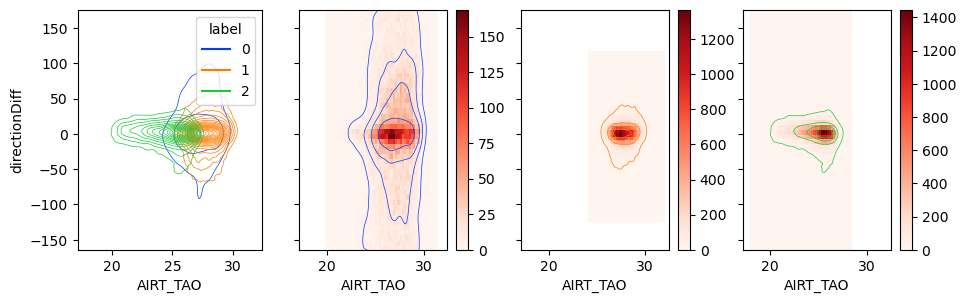

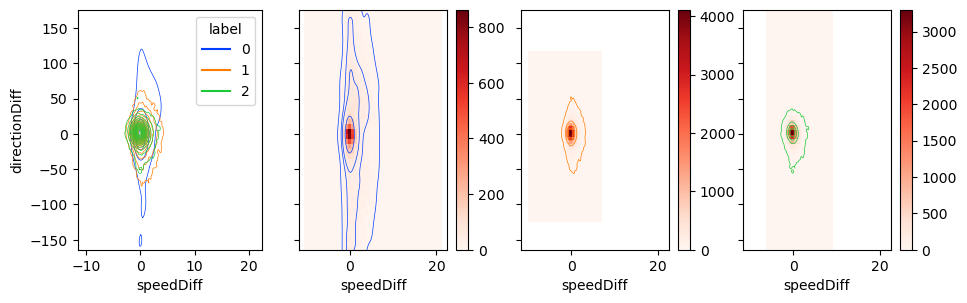

In [31]:
for i in range(1, len(subDFheaders)-2):
    for j in range(i+1, len(subDFheaders)-1):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', hue='label', levels=20)

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)